## 1. import each dataset, cause it's large

In [14]:
from collections import defaultdict

def build_pairs(names):
    pairs = defaultdict(dict)
    for name in names:
        if name.startswith("raw_review_"):
            cat = name.replace("raw_review_", "")
            pairs[cat]["review"] = name
        elif name.startswith("raw_meta_"):
            cat = name.replace("raw_meta_", "")
            pairs[cat]["meta"] = name
    return pairs

with open("datasets.txt", "r") as f:
    names = [line.strip() for line in f if line.strip()]

pairs = build_pairs(names)

for i, (cat, pair) in enumerate(pairs.items()):
    if i == 10: break
    print(cat, "=>", pair)


All_Beauty => {'meta': 'raw_meta_All_Beauty', 'review': 'raw_review_All_Beauty'}
Toys_and_Games => {'meta': 'raw_meta_Toys_and_Games', 'review': 'raw_review_Toys_and_Games'}
Cell_Phones_and_Accessories => {'meta': 'raw_meta_Cell_Phones_and_Accessories', 'review': 'raw_review_Cell_Phones_and_Accessories'}
Industrial_and_Scientific => {'meta': 'raw_meta_Industrial_and_Scientific', 'review': 'raw_review_Industrial_and_Scientific'}
Gift_Cards => {'meta': 'raw_meta_Gift_Cards', 'review': 'raw_review_Gift_Cards'}
Musical_Instruments => {'meta': 'raw_meta_Musical_Instruments', 'review': 'raw_review_Musical_Instruments'}
Electronics => {'meta': 'raw_meta_Electronics', 'review': 'raw_review_Electronics'}
Handmade_Products => {'meta': 'raw_meta_Handmade_Products', 'review': 'raw_review_Handmade_Products'}
Arts_Crafts_and_Sewing => {'meta': 'raw_meta_Arts_Crafts_and_Sewing', 'review': 'raw_review_Arts_Crafts_and_Sewing'}
Baby_Products => {'meta': 'raw_meta_Baby_Products', 'review': 'raw_review_Ba

In [ ]:
from datasets import load_dataset

category = "CDs_and_Vinyl"
review_name = pairs[category]["review"]
meta_name = pairs[category]["meta"] 
# Load CDs_and_Vinyl reviews
dataset_review = load_dataset("McAuley-Lab/Amazon-Reviews-2023", review_name, split="full")
dataset_meta = load_dataset("McAuley-Lab/Amazon-Reviews-2023", meta_name, split="full")
print(dataset_review)
print(dataset_meta)
print("Number of feature in dataset_review:", len(dataset_review.features))
print("Number of feature in dataset_meta:", len(dataset_meta.features))

# Count unique users and items
n_users = len(set(dataset_review["user_id"]))
n_items = len(set(dataset_review["asin"]))
n_reviews = len(dataset_review)

n_categories = len(set(dataset_meta["main_category"]))

print(f"#Categories: {n_categories:,}")
print(f"#Users: {n_users:,}")
print(f"#Items: {n_items:,}")
print(f"#Reviews: {n_reviews:,}")



Dataset({
    features: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase'],
    num_rows: 4827273
})
Dataset({
    features: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together', 'subtitle', 'author'],
    num_rows: 701959
})
Number of feature in dataset_review: 10
Number of feature in dataset_meta: 16
#Categories: 30
#Users: 1,754,118
#Items: 701,706
#Reviews: 4,827,273


AttributeError: 'list' object has no attribute 'nunique'

In [ ]:
print(dataset_review[0])
print(dataset_meta[0])
dataset_review['parent_asin'] = dataset_review['parent_asin'].astype(str)
print(dataset_review['parent_asin'].nunique())

{'rating': 5.0, 'title': 'Five Stars', 'text': 'LOVE IT!', 'images': [], 'asin': 'B002MW50JA', 'parent_asin': 'B002MW50JA', 'user_id': 'AGKASBHYZPGTEPO6LWZPVJWB2BVA', 'timestamp': 1452650777000, 'helpful_vote': 0, 'verified_purchase': True}
{'main_category': 'Digital Music', 'title': 'Release Some Tension', 'average_rating': 4.6, 'rating_number': 112, 'features': [], 'description': ['Swv ~ Release Some Tension'], 'price': '12.05', 'images': {'hi_res': ['https://m.media-amazon.com/images/I/71VRDLrTvYL._SL1500_.jpg'], 'large': ['https://m.media-amazon.com/images/I/517h9OROQAL.jpg'], 'thumb': ['https://m.media-amazon.com/images/I/517h9OROQAL._SS40_.jpg'], 'variant': ['MAIN']}, 'videos': {'title': [], 'url': [], 'user_id': []}, 'store': 'SWV   Format: Audio CD', 'categories': ['CDs & Vinyl', 'Dance & Electronic', 'House'], 'details': '{"Is Discontinued By Manufacturer": "No", "Product Dimensions": "5.62 x 4.92 x 0.33 inches; 3.84 Ounces", "Manufacturer": "Sony Legacy", "Item model number":

AttributeError: 'Dataset' object has no attribute 'groupby'

## 2. EDA


In [55]:
import pandas as pd
df_review = dataset_review.to_pandas()
df_meta = dataset_meta.to_pandas()
df_review.head(10)


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Five Stars,LOVE IT!,[],B002MW50JA,B002MW50JA,AGKASBHYZPGTEPO6LWZPVJWB2BVA,1452650777000,0,True
1,5.0,Five Stars,LOVE!!,[],B008XNPN0S,B008XNPN0S,AGKASBHYZPGTEPO6LWZPVJWB2BVA,1452650764000,0,True
2,3.0,Three Stars,Sad there is not the versions with the real/or...,[],B00IKM5N02,B00IKM5N02,AGKASBHYZPGTEPO6LWZPVJWB2BVA,1452649885000,0,True
3,3.0,Disappointed,I have listen to The Broadway 1958 Flower Drum...,[],B00006JKCM,B00006JKCM,AEVWAM3YWN5URJVJIZZ6XPD2MKIA,1164036864000,3,True
4,5.0,Wonderful melding,Simply great album. One of the best. Marvelous...,[],B00013YRQY,B00013YRQY,AFWHJ6O3PV4JC7PVOJH6CPULO2KQ,1582090199946,0,False
5,5.0,Magnificent movie & music score!,The sound is incredibly beautiful. If you like...,[],B07Z76Y18X,B07Z76Y18X,AFWHJ6O3PV4JC7PVOJH6CPULO2KQ,1576100171173,5,True
6,5.0,Five Stars,beautiful music!,[],B00004NKAK,B00004NKAK,AFWHJ6O3PV4JC7PVOJH6CPULO2KQ,1524768111415,0,True
7,5.0,Great,Excellent album one of my favorites,[],B0000062P5,B0000062P5,AFWHJ6O3PV4JC7PVOJH6CPULO2KQ,1504898965457,0,True
8,5.0,YES...YES!!!!,Excellent for guitar lovers! His other CDS are...,[],B00EC6VQDS,B00EC6VQDS,AFWHJ6O3PV4JC7PVOJH6CPULO2KQ,1486090923000,0,True
9,4.0,Good album,Such a talented lady. We lost her to soon. She...,[],B002HMHR7S,B002HMHR7S,AFWHJ6O3PV4JC7PVOJH6CPULO2KQ,1402778050000,0,True


In [17]:
df_meta = df_meta[['parent_asin','main_category','title','average_rating','rating_number','features','description','price','images','categories','store']]
df_review =df_review[['asin','parent_asin','user_id','rating','title','text','timestamp','helpful_vote','verified_purchase','images']]
df_meta = df_meta.dropna(subset = ['parent_asin']).drop_duplicates(subset = ['parent_asin'])
df = df_review.merge(df_meta, on= 'parent_asin', how='left')
df.count()
df = df.sample(5000, random_state=42).reset_index(drop=True) #random sample 5000 rows for demo

## import CLIP model

In [18]:
import io, time, math, requests
from PIL import Image
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from transformers import CLIPModel, CLIPProcessor
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device).eval()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")



Using device: cuda


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## pick the best url for image chopped down 

In [19]:

import numpy as np

def pick_best_image_from_images_field(images_field):
    """
    Returns a single best URL given one row's images field.
    Prefers hi_res MAIN -> hi_res any -> large MAIN -> large any -> thumb MAIN -> thumb any.
    Returns None if nothing usable.
    """
    if images_field is None:
        return None

    # Some splits may store images as a plain list of URLs (reviews_x). Handle that too.
    if isinstance(images_field, (list, tuple)):
        return images_field[0] if images_field else None

    # Expect dict with arrays
    if isinstance(images_field, dict):
        # Normalize to python lists
        def to_list(x):
            if x is None: return []
            if isinstance(x, np.ndarray): return x.tolist()
            if isinstance(x, (list, tuple)): return list(x)
            return []

        hi_res   = to_list(images_field.get('hi_res'))
        large    = to_list(images_field.get('large'))
        thumb    = to_list(images_field.get('thumb'))
        variant  = to_list(images_field.get('variant'))

        # If no variant provided, just prefer hi_res->large->thumb by first URL
        if not variant:
            for arr in (hi_res, large, thumb):
                if arr: return arr[0]
            return None

        # Build aligned records
        L = max(len(hi_res), len(large), len(thumb), len(variant))
        recs = []
        for i in range(L):
            v = variant[i] if i < len(variant) else None
            recs.append({
                'variant': v,
                'hi_res': hi_res[i] if i < len(hi_res) else None,
                'large':  large[i]  if i < len(large)  else None,
                'thumb':  thumb[i]  if i < len(thumb)  else None,
            })

        # Priority helpers
        def first_where(key, cond=lambda r: True):
            for r in recs:
                if cond(r) and r.get(key): return r[key]
            return None

        # Try in order of preference
        return ( first_where('hi_res',  lambda r: r['variant'] == 'MAIN')
              or first_where('hi_res')
              or first_where('large',   lambda r: r['variant'] == 'MAIN')
              or first_where('large')
              or first_where('thumb',   lambda r: r['variant'] == 'MAIN')
              or first_where('thumb') )

    # Fallback: unknown type
    return None

## 
df['img_url'] = df['images_y'].apply(pick_best_image_from_images_field)


# Tới đây là process tải một đống ảnh về rồi convert thông qua CLIP nha ae, convert xong rồi thì store vào 1 cột 

In [20]:
import os, io, requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from PIL import Image
import numpy as np
import torch

SESSION = requests.Session()
SESSION.headers.update({"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119 Safari/537.36"})

def fetch_image_bytes(url, timeout=2.5, max_kb=4096):
    try:
        r = SESSION.get(url, timeout=timeout, stream=True)
        r.raise_for_status()
        b = r.content
      
        # Max cap ~4 MB (change if needed)
        if len(b) > max_kb * 1024:
            return 
        return b
    except Exception:
        return None

def to_pil(b):
    if b is None:
        return None
    try:
        return Image.open(io.BytesIO(b)).convert("RGB")
    except Exception:
        return None


# day la ham push cai hinh anh vao trong cai model clip
@torch.no_grad()
def embed_pil_batch(pil_list, batch_size=64 if torch.cuda.is_available() else 16):
    # keep positions of valid PILs
    keep_idx, images = [], []
    for i, im in enumerate(pil_list):
        if im is not None:
            keep_idx.append(i)
            images.append(im)

    embs = [None] * len(pil_list)
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        inputs = processor(images=batch, return_tensors="pt").to(device)
        feats = model.get_image_features(**inputs)
        feats = torch.nn.functional.normalize(feats, p=2, dim=1).cpu().numpy()
        for j, vec in enumerate(feats):
            embs[keep_idx[i+j]] = vec
    return embs


mask = df["img_url"].notna()
work = df.loc[mask, ["parent_asin", "img_url"]].drop_duplicates("parent_asin").copy()
print(len(work))
# SAMPLE SIZE — tuy` chinh theo kha` nang xu ly
SAMPLE = 5000
if len(work) > SAMPLE:
    work = work.sample(SAMPLE, random_state=42).reset_index(drop=True)

print("Images to process:", len(work))

# Parallel download (fast I/O)
# Download images in parallel threads va dc store duoi dang bytes, sau do chuyen thanh PIL
N_WORKERS = 48  

bytes_list = [None] * len(work)
with ThreadPoolExecutor(max_workers=N_WORKERS) as ex:
    futs = {ex.submit(fetch_image_bytes, url): i for i, url in enumerate(work["img_url"])}
    for fut in tqdm(as_completed(futs), total=len(futs), desc="Downloading"):
        i = futs[fut]
        bytes_list[i] = fut.result()


4746
Images to process: 4746


Downloading: 100%|██████████| 4746/4746 [03:09<00:00, 25.08it/s]


In [21]:
# Convert to PIL
work["pil"] = [to_pil(b) for b in bytes_list]
ok_rate = work["pil"].notna().mean()
print(f"Download OK rate: {ok_rate:.1%}")

# Batched CLIP embedding (with periodic checkpoints)
# chia batch ra 2000
EMBATCH = 2000   # rows per embedding chunk (not CLIP batch)
vecs = [None] * len(work)
for s in range(0, len(work), EMBATCH):
    sub = work.iloc[s:s+EMBATCH]
    embs = embed_pil_batch(sub["pil"].tolist())
    for j, v in enumerate(embs):
        vecs[s + j] = v

work["clip_img_emb"] = vecs
work = work.drop(columns=["pil"])

# Keep only successful embeddings, one per parent_asin
emb_df = work.loc[work["clip_img_emb"].notna(), ["parent_asin", "clip_img_emb"]].drop_duplicates("parent_asin")

# Save (parquet with list-of-floats)
emb_out = emb_df.copy()
emb_out["clip_img_emb"] = emb_out["clip_img_emb"].apply(lambda v: v.tolist())
emb_out.to_parquet("clip_img_emb_parent.parquet", index=False)
print("Saved embeddings including [clip_img_emb, parent_asin]:", len(emb_out))

#merge back to df
df["parent_asin"] = df["parent_asin"].astype(str)
emb_out["parent_asin"] = emb_out["parent_asin"].astype(str)

df = df.merge(emb_out, on="parent_asin", how="left")
df["has_img_emb"] = df["clip_img_emb"].apply(lambda v: isinstance(v, np.ndarray))
df["clip_img_emb"] = df["clip_img_emb"].apply(lambda v: np.array(v, dtype=np.float32) if isinstance(v, np.ndarray) else np.zeros(512, dtype=np.float32))
# save final df
df.to_parquet(f"reviews_with_img_emb_{category}.parquet", index=False)


Download OK rate: 98.5%
Saved embeddings including [clip_img_emb, parent_asin]: 4673


<class 'numpy.ndarray'> 4918
Genre counts: {'Pop': 526, 'CDs $7 - $10': 297, "Today's Country": 181, 'Progressive Rock': 141, 'Album-Oriented Rock (AOR)': 133, 'Pop & Contemporary': 107, 'Rock': 92, 'Adult Contemporary': 86, 'Indie Rock': 84, 'Christmas': 80, 'Jazz': 77, 'Adult Alternative': 76, 'Vocal Pop': 74, 'Britain': 63, 'Traditional Pop': 55, 'Pop Metal': 55, 'Country': 52, 'Chamber Music': 51, 'Musicals': 51, 'Dance Pop': 47, 'CDs Under $7': 45, 'Alternative Rock': 45, 'Classical': 42, 'Punk': 41, 'Movie Scores': 40, 'Soul': 40, 'American Alternative': 40, 'Metal': 38, 'New Wave': 38, 'Electronica': 38, 'Symphonies': 37, 'Hard Rock': 36, 'Singer-Songwriters': 35, 'Meditation': 33, 'Bebop': 32, 'Contemporary Folk': 31, 'Pop Rap': 31, 'Soundtracks': 30, 'Blues': 30, 'Concertos': 29, 'Oldies': 29, 'Vinyl Store': 29, 'Bluegrass': 29, 'Progressive Metal': 28, 'Movie Soundtracks': 26, 'Disco': 26, 'Americana': 25, 'Psychedelic Rock': 25, 'Alternative Metal': 25, 'Rockabilly': 24, 'Co

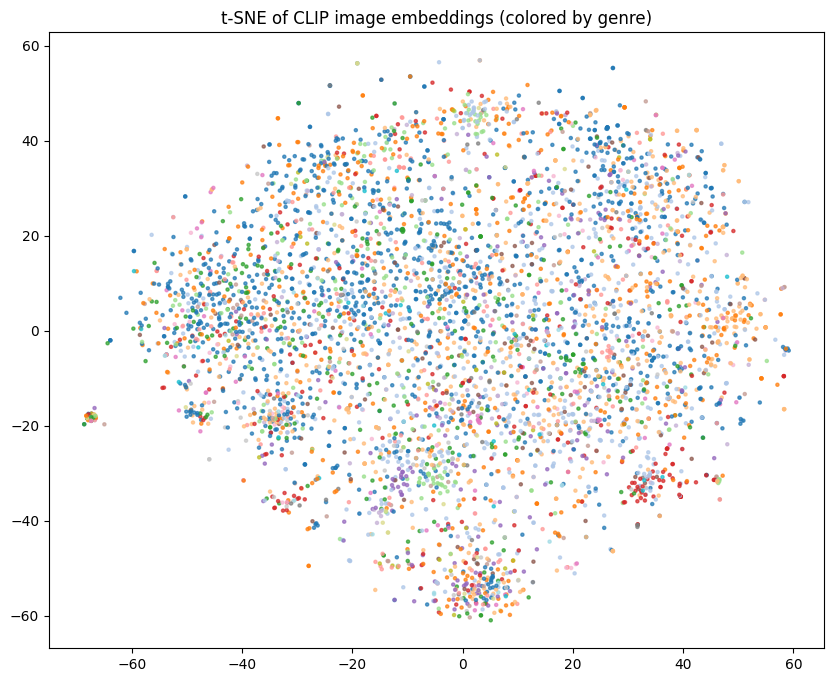

In [ ]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# Load embeddings (every row = one parent_asin with vector)
category = "CDs_and_Vinyl"
emb_df = pd.read_parquet("clip_img_emb_parent.parquet")
df = pd.read_parquet(f"reviews_with_img_emb_{category}.parquet")

emb_with_cat = emb_df.merge(
    df[["parent_asin", "categories"]], 
    on="parent_asin", 
    how="inner"
)

# Now extract embeddings + labels together
# lấy cái category cuối của cái mảng categories vì cái đầu đều là CD hoặc Vinyl
print(type(emb_with_cat["clip_img_emb"].values[0]), len(emb_with_cat))
X = np.stack(emb_with_cat["clip_img_emb"].values)
emb_with_cat["genre"] = emb_with_cat["categories"].apply(
    lambda x: x[-1] if len(x) > 0 else "Unknown"
)
labels = emb_with_cat["genre"]
print("Genre counts:", labels.value_counts().to_dict())

print("Shapes:", X.shape, len(labels))   
X_2d = TSNE(n_components=2, perplexity=30, metric="cosine", random_state=42).fit_transform(X)

plt.figure(figsize=(10,8))
plt.scatter(X_2d[:,0], X_2d[:,1],
            c=pd.factorize(labels)[0],
            cmap="tab20", s=5, alpha=0.7)
plt.title("t-SNE of CLIP image embeddings (colored by genre)")
plt.show()



c:\Users\RAZER\AppData\Local\Programs\Python\Python311\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


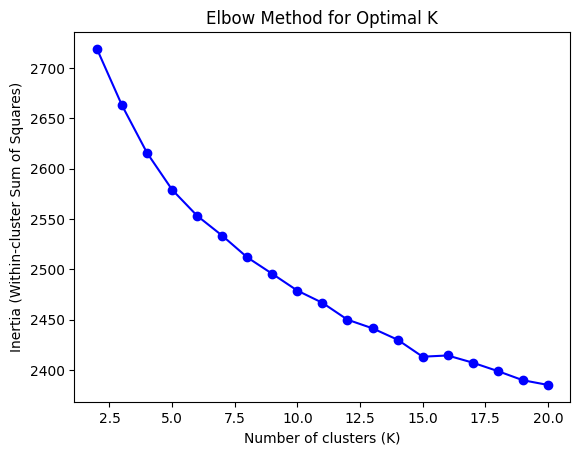

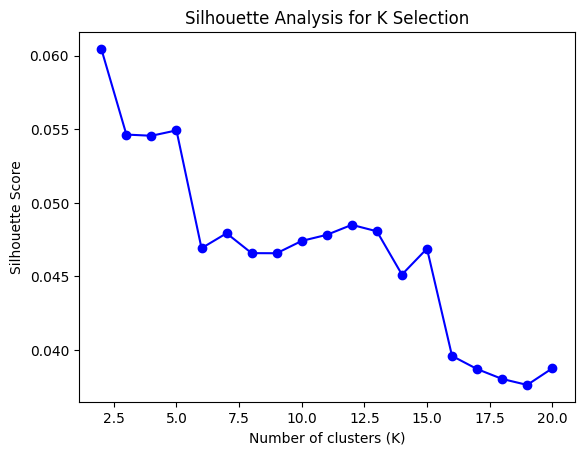

In [23]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score    

wcss = []
K_range = range(2, 21)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)   # X is your embedding matrix
    wcss.append(kmeans.inertia_)

plt.plot(K_range, wcss, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.show()

scores = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    preds = kmeans.fit_predict(X)
    score = silhouette_score(X, preds, metric='cosine')
    scores.append(score)

plt.plot(range(2, 21), scores, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for K Selection')
plt.show()



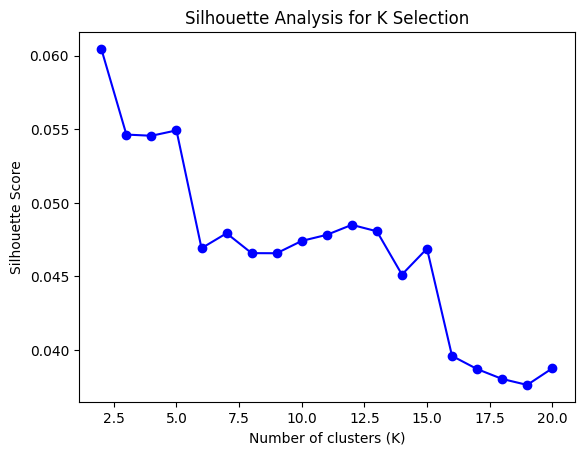

In [24]:
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    preds = kmeans.fit_predict(X)
    score = silhouette_score(X, preds, metric='cosine')
    scores.append(score)

plt.plot(range(2, 21), scores, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for K Selection')
plt.show()


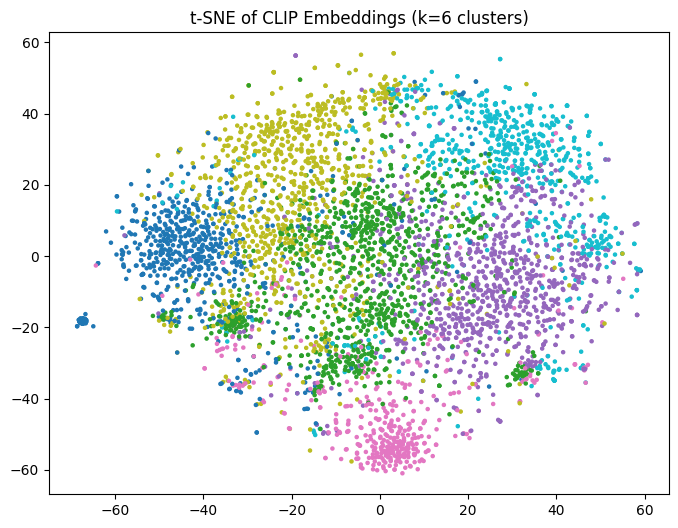

In [25]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(X)
plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=clusters, cmap="tab10", s=5)
plt.title("t-SNE of CLIP Embeddings (k=6 clusters)")
plt.show()


## K = 6  la phe nha ae, vì ở đây đang test xem cái embedding của CLIP có thực sự OK k, thì k = 6 cho ra khá tốt vì cluster được ra tốt và thực sự cái model CLIP chạy oke, k=6 vì lấy dựa trên 2 cái method Elbow với Silhoutte ở trên


In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize

def to_text(x):
    """Convert scalars/lists to a single clean string."""
    if x is None:
        return ""
    if isinstance(x, list):
        # description often is a list of strings
        return " ".join([str(t) for t in x if t is not None])
    return str(x)

# Review-side text: user-written title_x + review body text
df["review_text"] = (
    df.get("title_x", "").apply(to_text).fillna("") + " " +
    df.get("text", "").apply(to_text).fillna("")
).str.strip()

# Meta-side text: product title_y + product description
df["meta_text"] = (
    df.get("title_y", "").apply(to_text).fillna("") + " " +
    df.get("description", "").apply(to_text).fillna("")
).str.strip()

model_text = SentenceTransformer("all-MiniLM-L6-v2")

review_corpus = df["review_text"].tolist()
meta_corpus   = df["meta_text"].tolist()

review_emb = model_text.encode(
    review_corpus, batch_size=64, show_progress_bar=True, convert_to_numpy=True
).astype("float32")

meta_emb = model_text.encode(
    meta_corpus, batch_size=64, show_progress_bar=True, convert_to_numpy=True
).astype("float32")

print("review_emb:", review_emb.shape, "meta_emb:", meta_emb.shape)

# Fuse review + meta into one text vector 
# can tune alpha; start with more weight on review text or the other way around.
alpha = 0.7  # weight on review text; (1-alpha) on meta
text_emb = normalize(alpha * review_emb + (1 - alpha) * meta_emb, axis=1)
df["review_text_emb"] = list(review_emb)
df["meta_text_emb"]   = list(meta_emb)
df["text_emb"]        = list(text_emb.astype("float32"))  # fused text emb


df.to_parquet(f"reviews_with_img_text_emb_{category}.parquet", index=False)
print("Saved:", f"reviews_with_img_text_emb_{category}.parquet")



# cái này là df có gồm luôn cái text_emb (là cái title_x đã được encode thành vector)


# cái này là để chuẩn hoá vector, tức là đưa vector về cùng 1 độ dài, để khi tính cosine similarity thì nó sẽ đúng hơn, hình dung nó như là chuyển 1 câu review về một vector có 384 chiều

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

review_emb: (5000, 384) meta_emb: (5000, 384)
Saved: reviews_with_img_text_emb_CDs_and_Vinyl.parquet


In [65]:
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
import numpy as np
# Normalize the embeddings
E_txt = normalize(text_emb)   
# (N, D)

nbrs = NearestNeighbors(n_neighbors=10, metric="cosine").fit(E_txt)

def show_neighbors(idx, k=5):
    d, i = nbrs.kneighbors(E_txt[idx:idx+1], n_neighbors=k+1)
    return list(zip(i[0][1:], 1 - d[0][1:]))  # (neighbor_index, cosine_sim)

print(show_neighbors(123))


[(np.int64(3373), np.float32(0.7502746)), (np.int64(996), np.float32(0.7392601)), (np.int64(4065), np.float32(0.7081316)), (np.int64(3808), np.float32(0.70378196)), (np.int64(4567), np.float32(0.7008087))]


## FAISS

In [66]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
import faiss

# Load your image embedding df
emb_img = pd.read_parquet("clip_img_emb_parent.parquet")     # ['parent_asin','clip_img_emb']
# Load or build your text embedding df
emb_txt = pd.read_parquet("reviews_with_img_text_emb_CDs_and_Vinyl.parquet")        # ['parent_asin','title_emb']

# Ensure both keys are string type
emb_img['parent_asin'] = emb_img['parent_asin'].astype(str)
emb_txt['parent_asin'] = emb_txt['parent_asin'].astype(str)

# Merge to keep only rows that have BOTH embeddings
merged = emb_txt.merge(emb_img, on="parent_asin", how="inner")
merged = merged.rename(columns={
    "clip_img_emb_y": "clip_img_emb",
    "title_x": "title_reviews",
    "title_y": "title_meta"
}).drop(columns=["clip_img_emb_x"], errors="ignore")
df.head()

print("Merged:", merged.shape)
merged[["images_x", "title_meta"]]




Merged: (4918, 28)


,images_x,title_meta
0,[],Tilt
1,[],Modern Times
2,[],Meaning In The Static
3,[],Night Divides the Day: The Music of the Doors
4,[],Live in Colombia
...,...,...
4913,[],Love Somebody
4914,[],TNGHT
4915,[],Wagner: Overtures & Preludes: Overtures to The...
4916,[],Live at Billy Bob's Texas


# khúc này là merge cả review với clip thành tensor để process

In [67]:

E_txt = np.stack(merged["text_emb"].values).astype("float32")
E_img = np.stack(merged["clip_img_emb"].values).astype("float32")

E_txt_n = normalize(E_txt, axis=1)
E_img_n = normalize(E_img, axis=1)

# fuse them
E_item_concat = normalize(np.concatenate([E_txt_n, E_img_n], axis=1), axis=1)
print("Fused shape:", E_item_concat.shape)
print(E_item_concat[0][:5])  # first 5 dims of first vector


Fused shape: (4918, 896)
[-0.02006023 -0.00460696 -0.03035316 -0.04394842  0.02163375]


In [68]:
E_item = E_item_concat
index = faiss.IndexFlatIP(E_item.shape[1])
index.add(E_item)
query_vec = E_item[535]  # pick any product vector
print("Query vector shape:", query_vec.shape)
sims, ids = index.search(query_vec[None, :], k=20)
print(sims,     ids)
for i, s in zip(ids[0], sims[0]):
    print(f"{merged.iloc[i]['text']} (score={s:.3f})")


Query vector shape: (896,)
[[1.         0.68580467 0.6791188  0.65449464 0.6395253  0.63639486
  0.61968446 0.61111426 0.61008763 0.60979855 0.6075872  0.6048815
  0.60410804 0.6036483  0.6032293  0.6020582  0.59715927 0.59641266
  0.5947401  0.59364015]] [[ 535 3769  837  342 1519 3217 1285 4872  774 2107  336  983  203 3819
  4858 3292  505 3603 1954  930]]
A very mellow, fun album, but with plenty of musical treasure.  Dylan's originality never flags.  My favorite track is one which almost no one has mentioned, the closing &quot;Father of Night&quot;.  This song is a simple prayer which in less than 90 seconds achieves amazing force and a gripping and unforgettable mood. (score=1.000)
Probably my favorite Dylan compilation set! (score=0.686)
I'm sure we all know that this is one of the best albums ever made. It's certainly one of my favourite Dylan albums, as tracks like Visions of Johanna are simply superb. However, if you remember the vinyl version, you will have fond memories of 

In [ ]:
query_text = "Pink Floyd vibe"
q_emb = model_text.encode([query_text])[0]
q_emb = q_emb / np.linalg.norm(q_emb)

q_full = np.concatenate([q_emb, np.zeros(512)], axis=0)
q_full = q_full / np.linalg.norm(q_full)

sims, ids = index.search(q_full[None, :], k=10)
results = merged.iloc[ids[0]]
print(results)



            asin parent_asin                       user_id  rating  \
4836  B000E6UK5K  B000E6UK5K  AFWXUS7R6HWG2NIQZVJOMNVYIDUA     5.0   
3202  B000002C1X  B000002C1X  AE3HQYRZOSDFXGXUUDFE3DW2AZFA     5.0   
441   B00004BZ0N  B00004BZ0N  AGYR73SFEAY7MEUPOQ5UJSPDAQUA     3.0   
3360  B07F6NG84L  B07F6NG84L  AF7CZX6PORENLTI565ZJK53NC43Q     5.0   
2336  B00NQKWA6S  B00NQKWA6S  AGNI7LB6RW4FJNJKCKMB7VUJVHVQ     5.0   
730   B000002U0D  B000002U0D  AGYAVABGKJC6BWXFGOFO4XICLCBQ     3.0   
545   B0009G018Q  B0009G018Q  AFMFYBWU3UHN2NLFWBHP3MNV4TPA     5.0   
21    B004ZNB12O  B004ZNB12O  AETUSN5ETDGTFW3WBPZA3BUOTXYA     2.0   
4666  B00008CLOA  B00008CLOA  AFWOWRSISUTDVKHLLCHMX4LF27NA     5.0   
1607  B074JNTRTG  B074JNTRTG  AHEY6VLHAJKN4EVCGCW4OFYJ3MHQ     5.0   

                                          title_reviews  \
4836                                    Heavenly Island   
3202  The greatest album from the greatest band of a...   
441       Kinda good but they be ripping off pink fl

In [69]:
import gradio as gr

def recommend(query):
    q_emb = model_text.encode([query])[0]
    q_emb = np.concatenate([q_emb, np.zeros(512)], axis=0)
    q_emb /= np.linalg.norm(q_emb)
    sims, ids = index.search(q_emb[None, :], k=6)
    return [merged.iloc[i]["img_url"] for i in ids[0]]

gr.Interface(fn=recommend, inputs="text", outputs=gr.Gallery()).launch()


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
